In [2]:
import pandas as pd
import numpy as np
seed = 12345
np.random.seed(seed)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.2)

from sklearn.decomposition import PCA
from tqdm import tqdm

weekdays = ['Tue', 'Fri']
var_list = ['Co', 'Gom', 'Env', 'Epg', 'Bbl', 'Rpc', 'Ep']

In [3]:
def read_old_df(end_of_week):
    if end_of_week == 'Fri':
        old = pd.read_stata('transformed_data_prices_v19.dta')
    elif end_of_week == 'Tue':
        old = pd.read_stata('transformed_data_physical_v19.dta')
    old['date'] = old[f'date_{end_of_week}']
    return old

def read_new_df(marker=None):
    if marker:
        df_daily = pd.read_csv(f'NYtime_daily_level_measures_C_2023_{marker}.csv')
    else:
        df_daily = pd.read_csv('NYtime_daily_level_measures_C_2023.csv')
    df_daily['date'] = pd.to_datetime(df_daily['date'], format='%Y%m%d')
    df_daily.set_index('date', inplace=True)
    return df_daily

def get_df_4wk(df_daily, end_of_week):
    old = read_old_df(end_of_week)
    df_weekly = df_daily.resample(f'W-{end_of_week.upper()}').mean()
    df_4wk = df_weekly.rolling(4).mean()
    df_4wk = df_4wk.merge(old, on='date')
    df_weekly = df_weekly.merge(old, on='date') 
    return df_4wk, df_weekly

def get_new2old(end_of_week, n_topics):
    new2old = {}
    new2old['article count_4wk'] = f'artcount_4wk_{end_of_week}'
    new2old['entropy_4wk'] = f'entropy_4wk_{end_of_week}'
    new2old['entropy'] = f'entropy_{end_of_week}'
    for i in range(n_topics):
        new2old[f'Topic {i+1}_4wk'] = f'ftopic{i+1}_4wk_{end_of_week}'
        new2old[f'Topic-Sentiment {i+1}_4wk'] = f'stopic{i+1}_4wk_{end_of_week}'
    return new2old

def check(end_of_week, marker=None, threshold='2007-07-01', check_type='corr'):
    
    df_daily = read_new_df(marker)
    n_topics = sum([i.startswith('Topic-Sentiment') for i in df_daily.columns])
    df_4wk, df = get_df_4wk(df_daily, end_of_week)
    
    new2old = get_new2old(end_of_week, n_topics)
    oldLabels = [i[:-4] for i in list(new2old.values())]
    df_check = pd.DataFrame(index=['all','prior','post'], columns=oldLabels)
    df_check.index.name = end_of_week
    for new, old in new2old.items():
        if new.endswith('4wk'):
            new_prefix = new[:-4]
            df_sub = df_4wk.dropna(subset=[new_prefix, old])
        else:
            df_sub = df.dropna(subset=[new_prefix, old])
        df_prior = df_sub[df_sub['date'] < threshold]
        df_post = df_sub[df_sub['date'] >= threshold]
        if check_type == 'corr':
            df_check[old[:-4]]['all'] = np.corrcoef(df_sub[new_prefix], df_sub[old]).min()
            df_check[old[:-4]]['prior'] = np.corrcoef(df_prior[new_prefix], df_prior[old]).min()
            df_check[old[:-4]]['post'] = np.corrcoef(df_post[new_prefix], df_post[old]).min()
        elif check_type.startswith('mean'):
            df_check[old[:-4]]['all'] = df_sub[new_prefix].mean() / df_sub[old].mean()
            df_check[old[:-4]]['prior'] = df_prior[new_prefix].mean() / df_prior[old].mean()
            df_check[old[:-4]]['post'] = df_post[new_prefix].mean() / df_post[old].mean()
        elif check_type.startswith('std'):
            df_check[old[:-4]]['all'] = df_sub[new_prefix].std() / df_sub[old].std()
            df_check[old[:-4]]['prior'] = df_prior[new_prefix].std() / df_prior[old].std()
            df_check[old[:-4]]['post'] = df_post[new_prefix].std() / df_post[old].std()
        else:
            df_check = None
    
    return df_check.astype(float)

def standardize(df):
#     if window:
#         rolling_mean = df.rolling(window).mean()
#         rolling_std = df.rolling(window).std()
#         df_scaled = (df - rolling_mean)/ rolling_std
#         return df_scaled.dropna()
#     else:
    return (df - df.mean())/ df.std()

In [4]:
def get_pc1(df_var, scale=False):
    pca = PCA(n_components=1, random_state=seed)
    if scale:
        pca_var = pca.fit_transform(standardize(df_var))
    else:
        pca_var = pca.fit_transform(df_var)
    pca_var = np.squeeze(pca_var)
    return pca_var

def plot_check_pca(pca_var, old_var, title, label='replicated'):
    fig, ax = plt.subplots(figsize=(18,6))
    corr = np.corrcoef(pca_var, old_var).min()
    ax.plot(pca_var, label=f'{label} (Corr={corr:.5f})')
    ax.plot(old_var, '.g', label='old')
    ax.set_title(f'Replicated PCA{title}')
    ax.legend();
    return fig, ax

In [4]:
end_of_week = 'Fri'
old = read_old_df(end_of_week)
df = old.copy()
#n_topics = sum([i.startswith('Topic-Sentiment') for i in df_daily.columns])
for var_prefix in ['f', 's']:
    var_cols = [f"{var_prefix}{var}_{end_of_week}" for var in var_list]
    df[var_cols] = standardize(df[[f'{var_prefix}topic{i+1}_4wk_{end_of_week}' for i in range(7)]])
    assert (df[var_cols] - old[var_cols]).max().max() < 1e-5

In [5]:
for marker in ['acc', 'mod']: # [None]:
    df_daily = read_new_df(marker)
    n_topics = sum([i.startswith('Topic-Sentiment') for i in df_daily.columns])

    for end_of_week in weekdays:

        df_4wk, df_weekly = get_df_4wk(df_daily, end_of_week)

        old = read_old_df(end_of_week)
        df = old.copy()
        df[f'entropy_{end_of_week}'] = df_weekly['entropy']
        df[f'artcount_{end_of_week}'] = df_weekly['article count']
        df[f'entropy_4wk_{end_of_week}'] = df_4wk['entropy']
        df[f'artcount_4wk_{end_of_week}'] = df_4wk['article count']

        fvar_ids = [f'ftopic{i+1}_4wk_{end_of_week}' for i in range(n_topics)]
        svar_ids = [f'stopic{i+1}_4wk_{end_of_week}' for i in range(n_topics)]
        df[fvar_ids] = df_4wk[[f'Topic {i+1}' for i in range(n_topics)]]
        df[svar_ids] = df_4wk[[f'Topic-Sentiment {i+1}' for i in range(n_topics)]]

        fvar_names = [f'f{var}_{end_of_week}' for var in var_list]
        svar_names = [f's{var}_{end_of_week}' for var in var_list]
        df[fvar_names] = standardize(df[fvar_ids])
        df[svar_names] = standardize(df[svar_ids])

        na_rows = df[fvar_names].isna().max(axis=1).sum()
        df[f'PCAfreq_{end_of_week}'] = [np.nan]*na_rows + list(get_pc1(df[fvar_names][na_rows:]))
        df[f'PCAsent_{end_of_week}'] = [np.nan]*na_rows + list(get_pc1(df[svar_names][na_rows:]))
        df[f'PCAall_{end_of_week}'] = [np.nan]*na_rows + list(get_pc1(df[fvar_names+svar_names][na_rows:]))

        df.drop(columns='date', inplace=True)
        
        if end_of_week == 'Fri':
            df.to_stata(f'transformed_data_prices_v19.2_{marker}.dta', write_index=False)
        elif end_of_week == 'Tue':
            df.to_stata(f'transformed_data_physical_v19.2_{marker}.dta', write_index=False)

In [8]:
marker = 'acc'
new = pd.read_stata(f'transformed_data_prices_v19.2_{marker}.dta')
old = pd.read_stata('transformed_data_prices_v19.dta')
assert new.columns.to_list() == old.columns.to_list()

print(np.corrcoef(new['PCAfreq_Fri'][3:], old['PCAfreq_Fri'][3:]).min())
print(np.corrcoef(new['PCAsent_Fri'][3:], old['PCAsent_Fri'][3:]).min())
print(np.corrcoef(new['PCAall_Fri'][3:], old['PCAall_Fri'][3:]).min())
print(np.corrcoef(new['fCo_Fri'][3:], old['fCo_Fri'][3:]).min())
print(np.corrcoef(new['sCo_Fri'][3:], old['sCo_Fri'][3:]).min())

print(np.corrcoef(new['entropy_Fri'][3:], old['entropy_Fri'][3:]).min())
print(np.corrcoef(new['artcount_Fri'][3:], old['artcount_Fri'][3:]).min())
print(np.corrcoef(new['entropy_4wk_Fri'][3:], old['entropy_4wk_Fri'][3:]).min())
print(np.corrcoef(new['artcount_4wk_Fri'][3:], old['artcount_4wk_Fri'][3:]).min())

0.9677920529781497Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
-0.9651994951149508
0.9761612822142487
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R

In [6]:
new = pd.read_stata('transformed_data_physical_v19.2.dta')
old = pd.read_stata('transformed_data_physical_v19.dta')
assert new.columns.to_list() == old.columns.to_list()

print(np.corrcoef(new['PCAfreq_Tue'][3:], old['PCAfreq_Tue'][3:]).min())
print(np.corrcoef(new['PCAsent_Tue'][3:], old['PCAsent_Tue'][3:]).min())
print(np.corrcoef(new['PCAall_Tue'][3:], old['PCAall_Tue'][3:]).min())
print(np.corrcoef(new['fCo_Tue'][3:], old['fCo_Tue'][3:]).min())
print(np.corrcoef(new['sCo_Tue'][3:], old['sCo_Tue'][3:]).min())

print(np.corrcoef(new['entropy_Tue'][3:], old['entropy_Tue'][3:]).min())
print(np.corrcoef(new['artcount_Tue'][3:], old['artcount_Tue'][3:]).min())
print(np.corrcoef(new['entropy_4wk_Tue'][3:], old['entropy_4wk_Tue'][3:]).min())
print(np.corrcoef(new['artcount_4wk_Tue'][3:], old['artcount_4wk_Tue'][3:]).min())

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
0.9869819849957037
0.9990014228245226
0.9923822586157628
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R)

In [34]:
df = pd.read_csv('/shared/share_mamaysky-glasserman/energy_drivers/2023/DataProcessing/concat/info_concatenate.csv')
df[[f'Topic{i+1}' for i in range(7)]].sum(axis=1)

0          1.0
1          1.0
2          1.0
3          1.0
4          1.0
          ... 
2280522    0.0
2280523    0.0
2280524    1.0
2280525    1.0
2280526    0.0
Length: 2280527, dtype: float64

- sXX are standardized stopic_4wk series => add to readme & comment
- why dropping fCo: 7 topic freq add up to 1?
- unclassified: article does not include any words from clustering_C.csv, so the sum of 7 topic allocations is 0

In [35]:
# need to be standardized
pd.read_stata('transformed_data_prices_v19.1.dta').columns

Index(['date_Fri', 'artcount_4wk_Fri', 'entropy_4wk_Fri', 'stopic1_4wk_Fri',
       'stopic2_4wk_Fri', 'stopic3_4wk_Fri', 'stopic4_4wk_Fri',
       'stopic5_4wk_Fri', 'stopic6_4wk_Fri', 'stopic7_4wk_Fri',
       'ftopic1_4wk_Fri', 'ftopic2_4wk_Fri', 'ftopic3_4wk_Fri',
       'ftopic4_4wk_Fri', 'ftopic5_4wk_Fri', 'ftopic6_4wk_Fri',
       'ftopic7_4wk_Fri', 'PCAfreq_Fri', 'PCAsent_Fri', 'PCAall_Fri'],
      dtype='object')

In [36]:
pd.read_stata('transformed_data_prices_v19.dta').columns

Index(['date_Tue', 'date_Wed', 'date_Thu', 'date_Fri', 'date_Mon',
       'FutRet_Fri', 'WIPI_4wk_monthly', 'WIPI_8wk_monthly', 'DSpot_Fri',
       'xomRet_Thu', 'bpRet_Thu', 'rdsaRet_Fri', 'StkIdx_ThFr', 'sp500Ret_Thu',
       'DProd_Wed', 'DInv_Wed', 'DFX_Thu', 'DOilVol_Thu', 'OilVol_Thu',
       'VIX_Thu', 'tnote_10y_Thu', 'basis_Fri', 'trend', 'artcount_4wk_Fri',
       'entropy_4wk_Fri', 'stopic1_4wk_Fri', 'ftopic1_4wk_Fri',
       'stopic2_4wk_Fri', 'ftopic2_4wk_Fri', 'stopic3_4wk_Fri',
       'ftopic3_4wk_Fri', 'stopic4_4wk_Fri', 'ftopic4_4wk_Fri',
       'stopic5_4wk_Fri', 'ftopic5_4wk_Fri', 'stopic6_4wk_Fri',
       'ftopic6_4wk_Fri', 'stopic7_4wk_Fri', 'ftopic7_4wk_Fri', 'entropy_Fri',
       'artcount_Fri', 'sCo_Fri', 'fCo_Fri', 'sGom_Fri', 'fGom_Fri',
       'sEnv_Fri', 'fEnv_Fri', 'sEpg_Fri', 'fEpg_Fri', 'sBbl_Fri', 'fBbl_Fri',
       'sRpc_Fri', 'fRpc_Fri', 'sEp_Fri', 'fEp_Fri', 'FutRet_t4_Fri',
       'FutRet_t8_Fri', 'DSpot_t4_Fri', 'DSpot_t8_Fri', 'xomRet_t4_Fri',
    

- include more: 'entropy_Fri',
       'artcount_Fri', 'sCo_Fri', 'fCo_Fri', 'sGom_Fri', 'fGom_Fri',
       'sEnv_Fri', 'fEnv_Fri', 'sEpg_Fri', 'fEpg_Fri', 'sBbl_Fri', 'fBbl_Fri',
       'sRpc_Fri', 'fRpc_Fri', 'sEp_Fri', 'fEp_Fri'
- v19.2 include all variables with new text concern (82 columns)

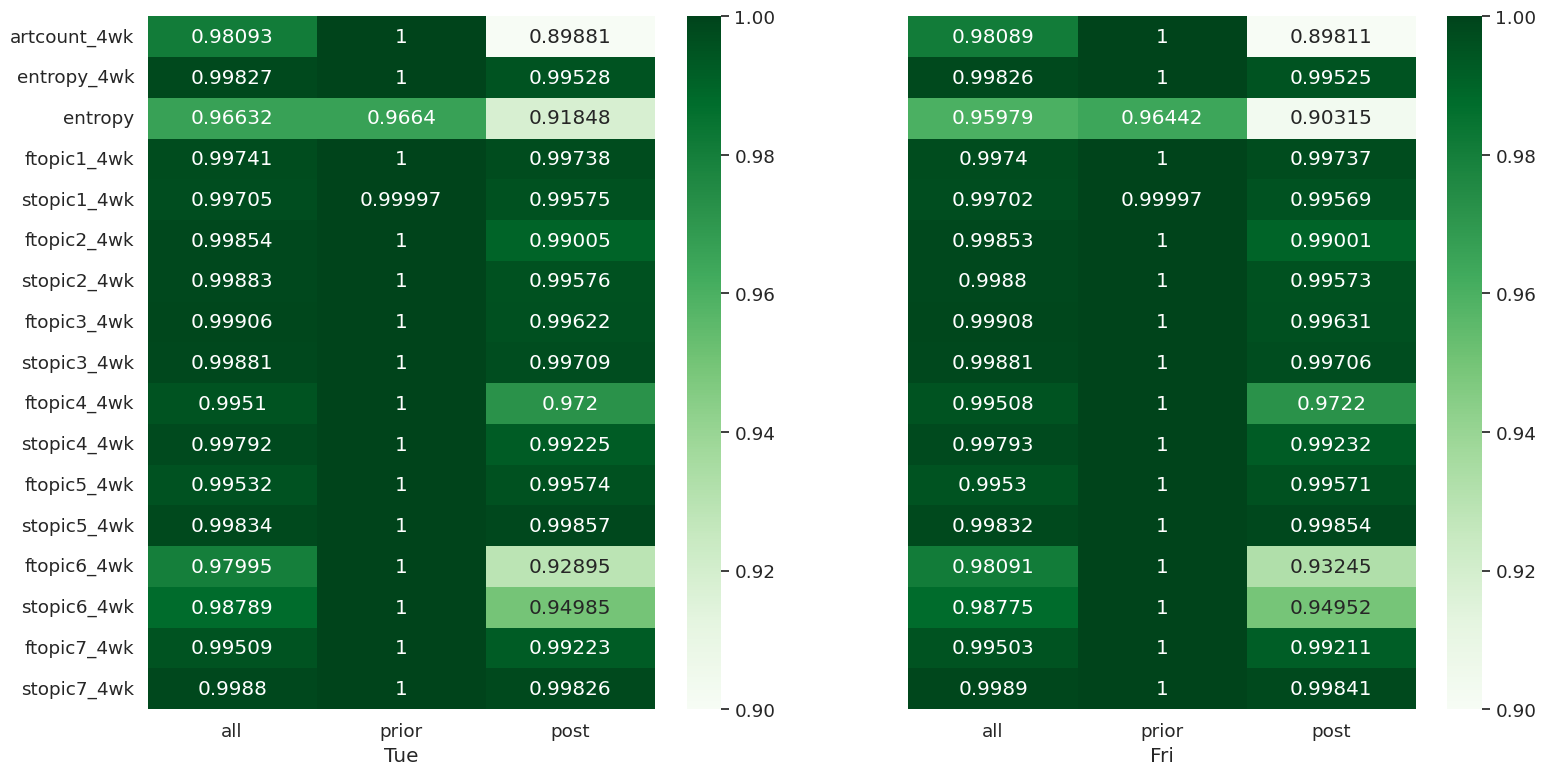

In [3]:
fig, ax = plt.subplots(figsize=(18,9), nrows=1, ncols=len(weekdays))
for i, end_of_week in enumerate(weekdays):
    sns.heatmap(check(end_of_week).T, annot=True, fmt='.5g', 
                cmap='Greens', vmin=0.9, vmax=1, ax=ax[i]);
    if i!=0:
        ax[i].set_yticklabels([])
plt.savefig('corr.pdf')

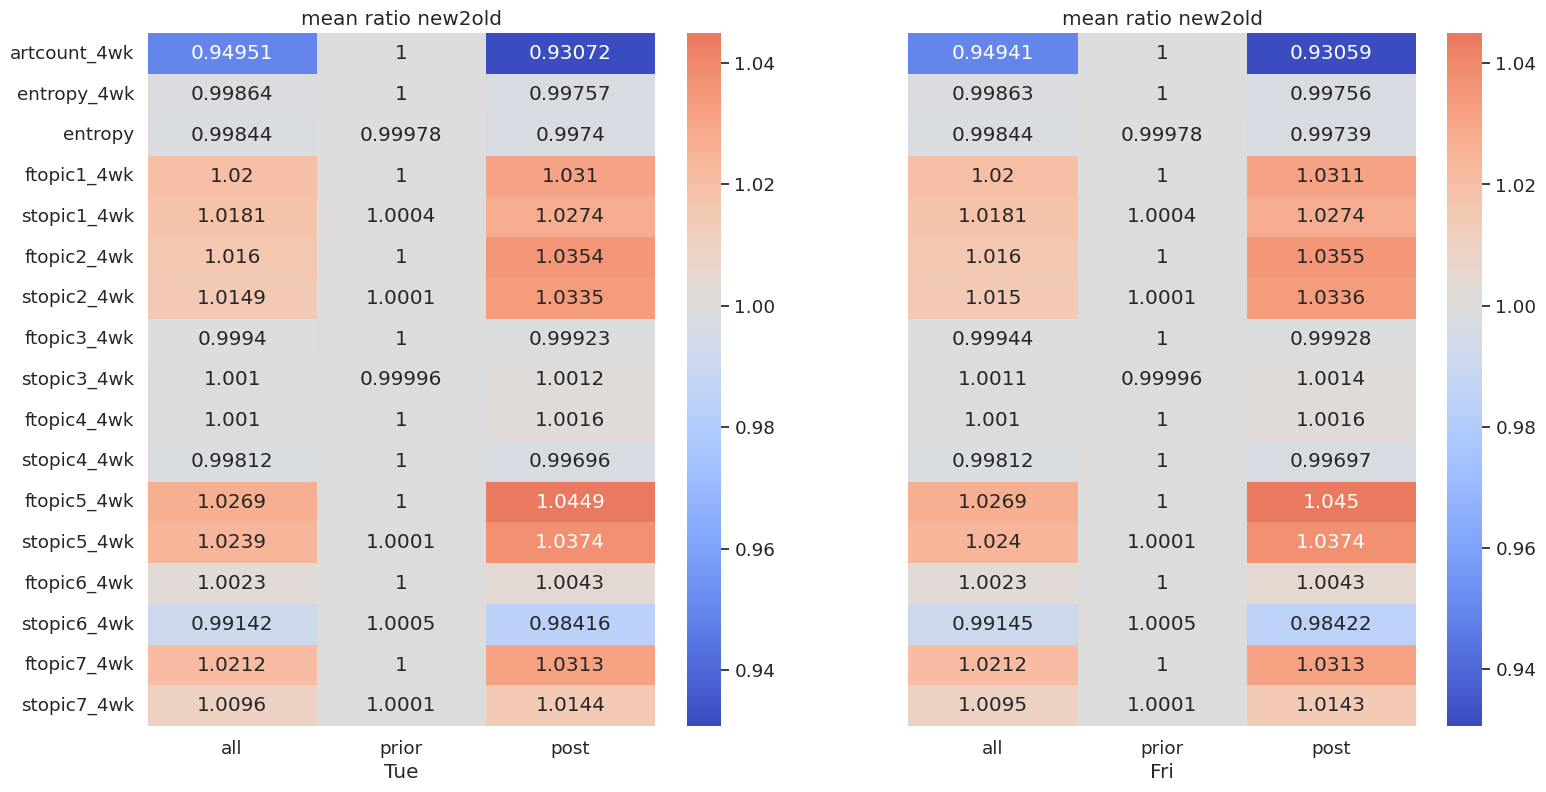

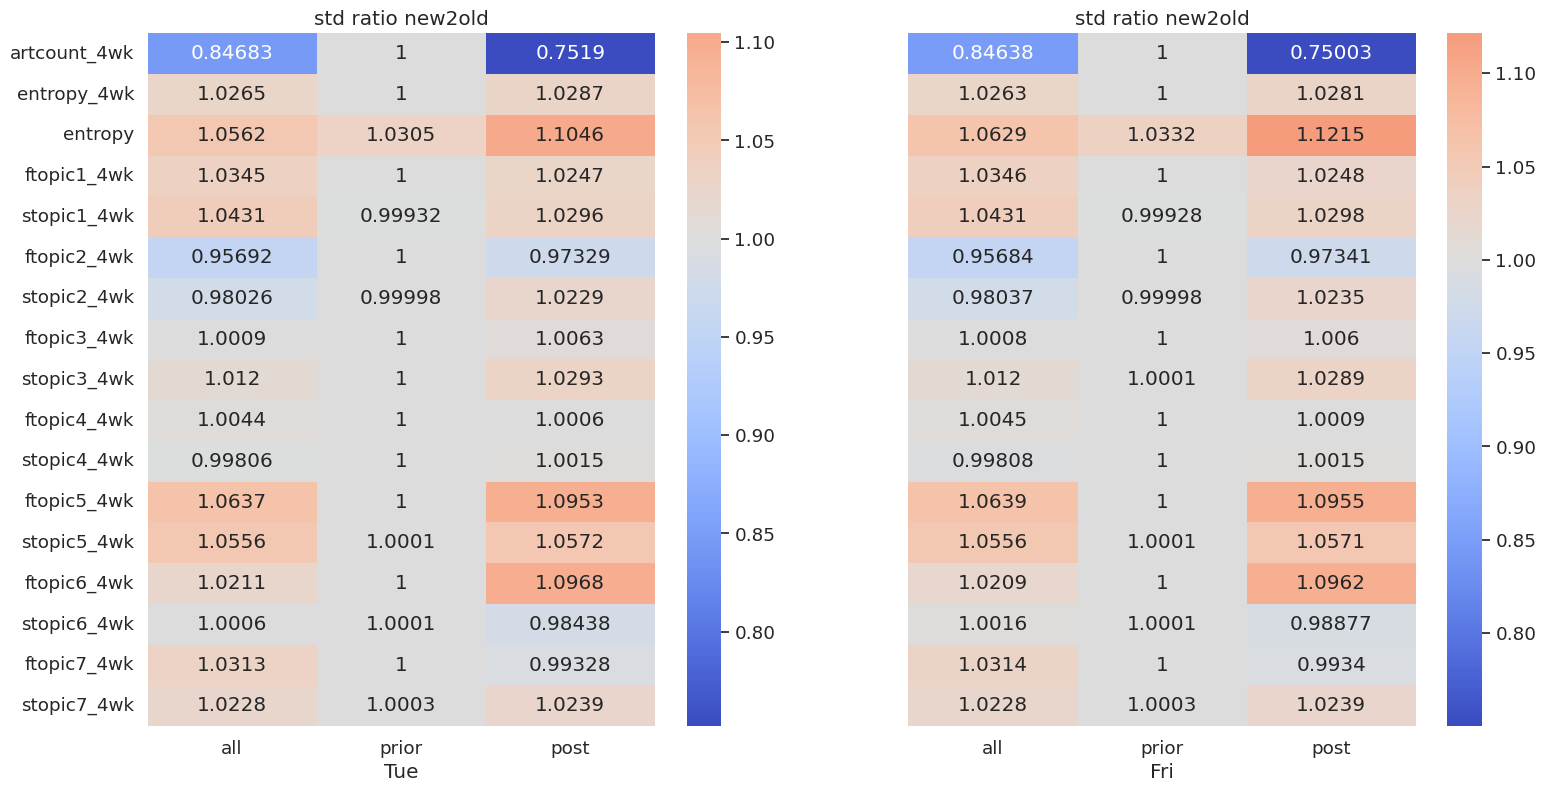

In [4]:
for title in ['mean ratio new2old', 'std ratio new2old']:
    fig, ax = plt.subplots(figsize=(18,9), nrows=1, ncols=len(weekdays))
    for i, end_of_week in enumerate(weekdays):
        sns.heatmap(check(end_of_week, check_type=title).T, annot=True, fmt='.5g', 
                    cmap='coolwarm', center=1, ax=ax[i]);
        ax[i].set_title(title)
        if i!=0:
            ax[i].set_yticklabels([])
    plt.savefig(f'{title}.pdf')

# PCA

## Reproducibility

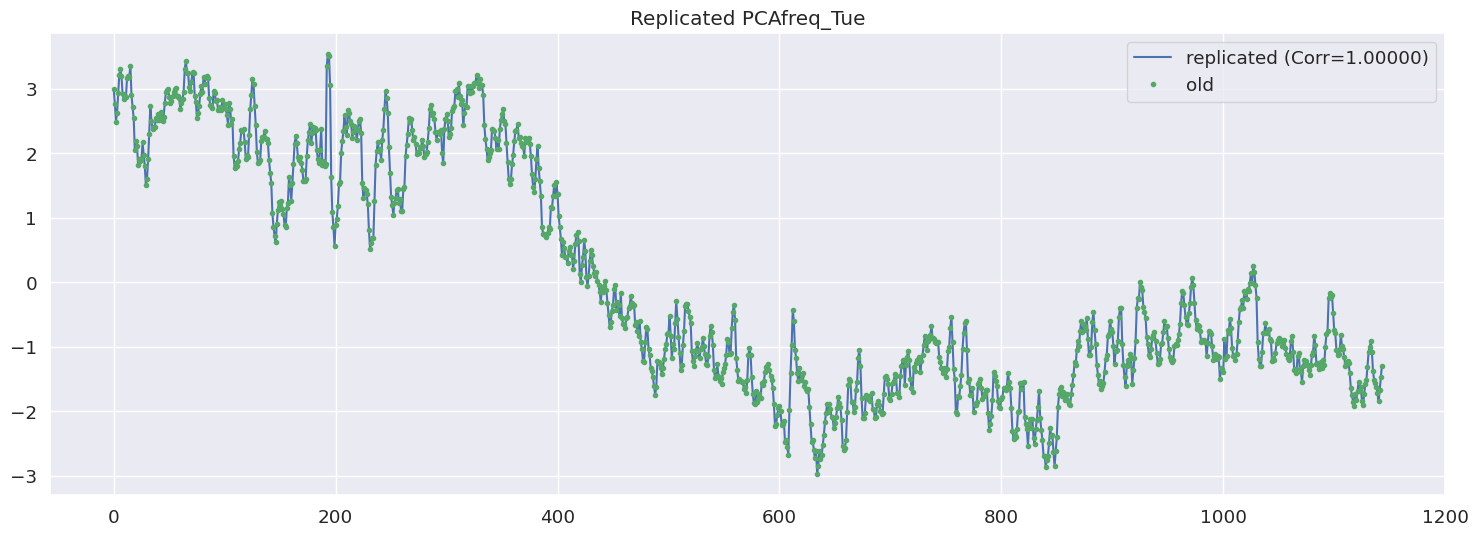

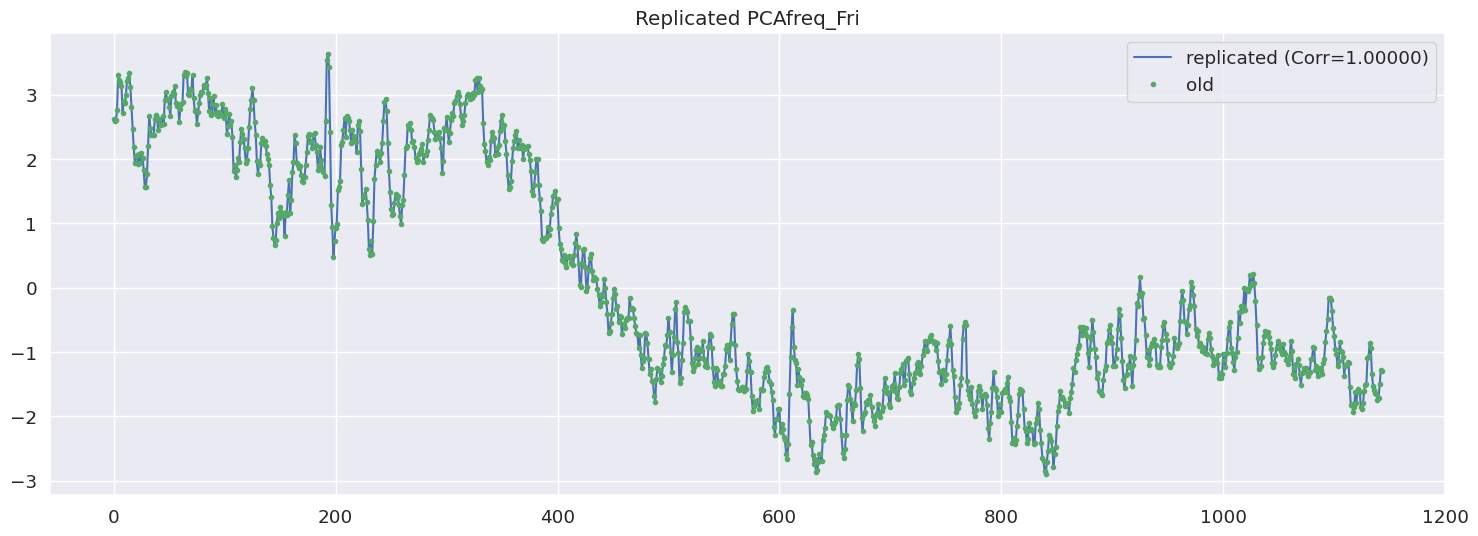

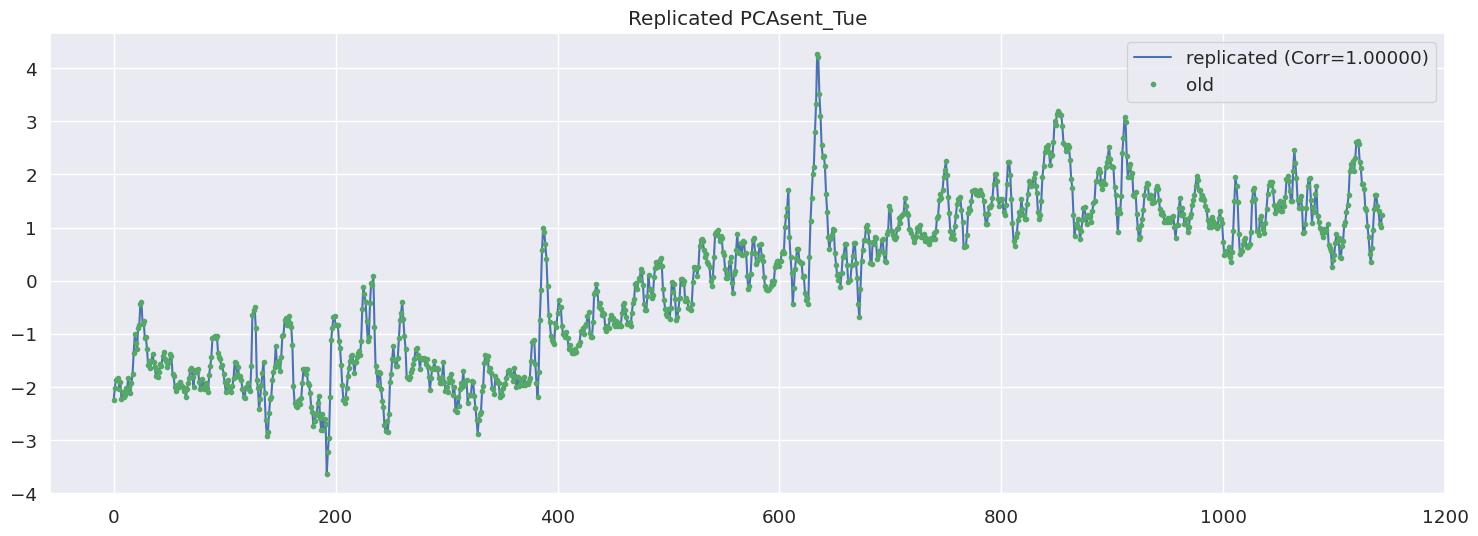

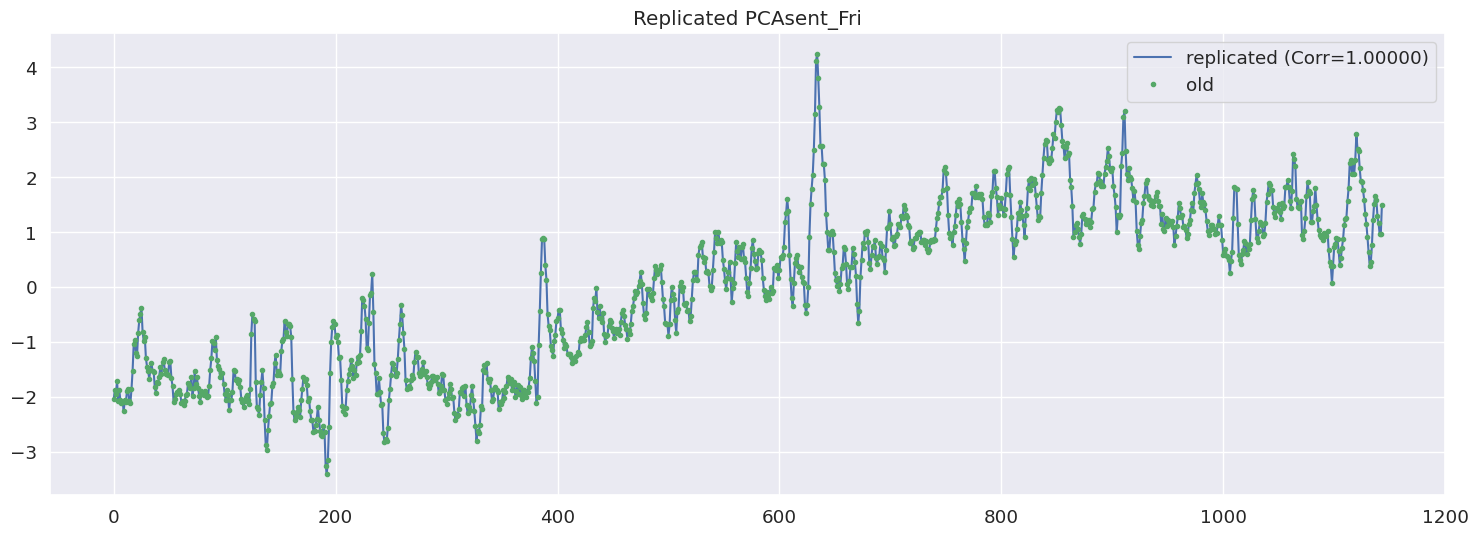

In [6]:
var_list = ['Co', 'Gom', 'Env', 'Epg', 'Bbl', 'Rpc', 'Ep']

for pca_var_name in ['freq', 'sent']:
    for end_of_week in weekdays:

        old = read_old_df(end_of_week)
        old_var = old[f'PCA{pca_var_name}_{end_of_week}'].dropna().values
        #freq_vars = [f'ftopic{i+1}_4wk_{end_of_week}' for i in range(n_topics)]
        col_vars = [f'{pca_var_name[0]}{i}' for i in var_list]
        col_vars_drop = col_vars.copy()
        try:
            col_vars_drop.remove(f'fCo')
        except ValueError:
            pass
        df_var = old[[f'{i}_{end_of_week}' for i in col_vars_drop]].dropna()
        pca_var = get_pc1(df_var)
        
        plot_check_pca(pca_var, old_var, title=f'{pca_var_name}_{end_of_week}')

## Non-determinism of PCA from sklearn
https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
- need to set seed
- error is small

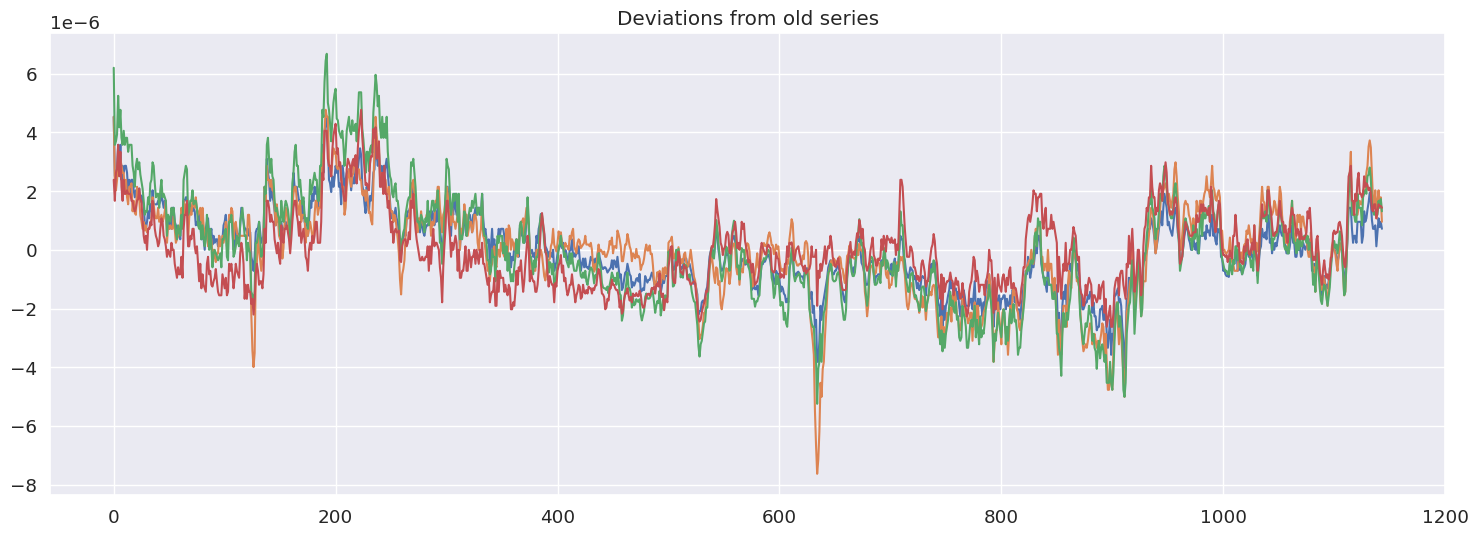

In [7]:
error_list = []
for _ in range(4):
    pca = PCA(n_components=1)
    pca_var = pca.fit_transform(df_var)
    pca_var = np.squeeze(pca_var)
    error_list.append(pca_var-old_var)
    
fig, ax = plt.subplots(figsize=(18,6))
ax.plot(np.array(error_list).T)
ax.set_title('Deviations from old series');

## What if: include 'fCo'

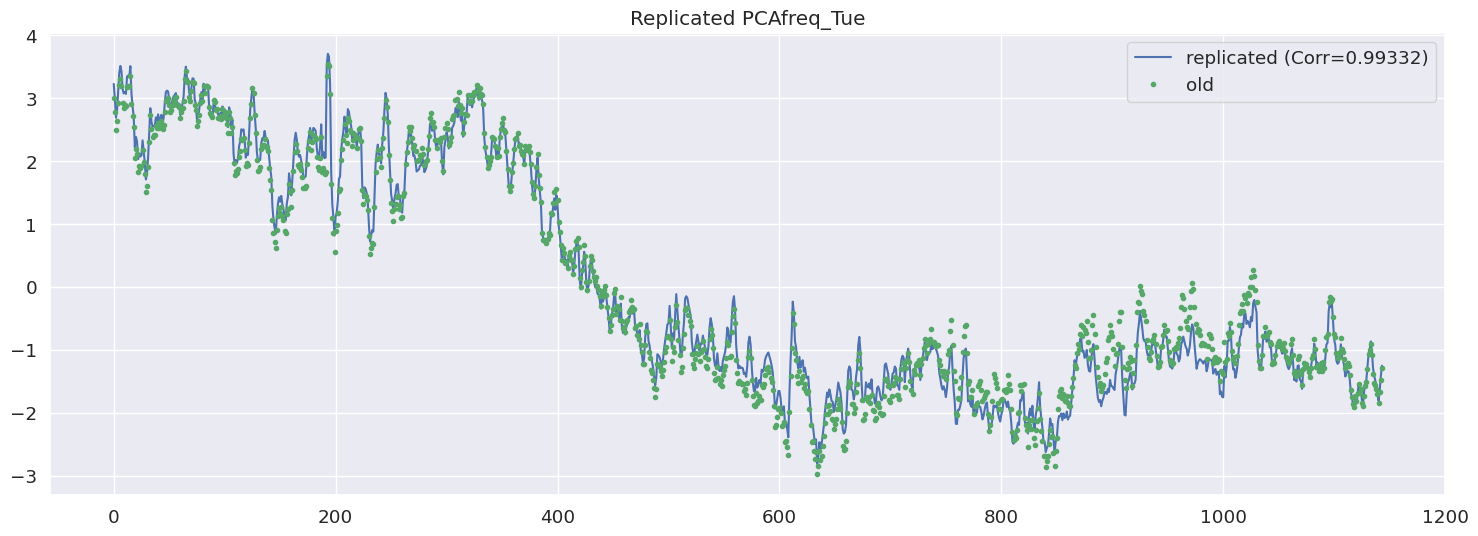

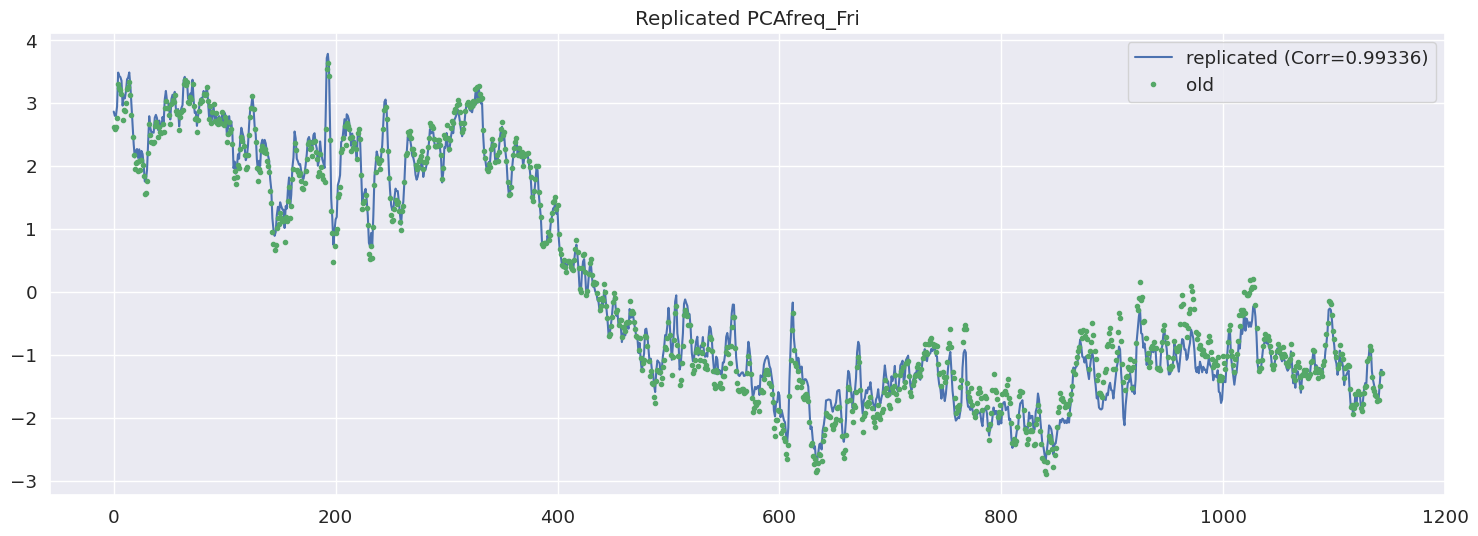

In [8]:
for pca_var_name in ['freq']:
    for end_of_week in weekdays:

        old = read_old_df(end_of_week)
        old_var = old[f'PCA{pca_var_name}_{end_of_week}'].dropna().values
        #freq_vars = [f'ftopic{i+1}_4wk_{end_of_week}' for i in range(n_topics)]
        col_vars = [f'{pca_var_name[0]}{i}' for i in var_list]
        df_var = old[[f'{i}_{end_of_week}' for i in col_vars]].dropna()
        pca_var = get_pc1(df_var)
        plot_check_pca(pca_var, old_var, title=f'{pca_var_name}_{end_of_week}')

## Decomposing 7 standardized series

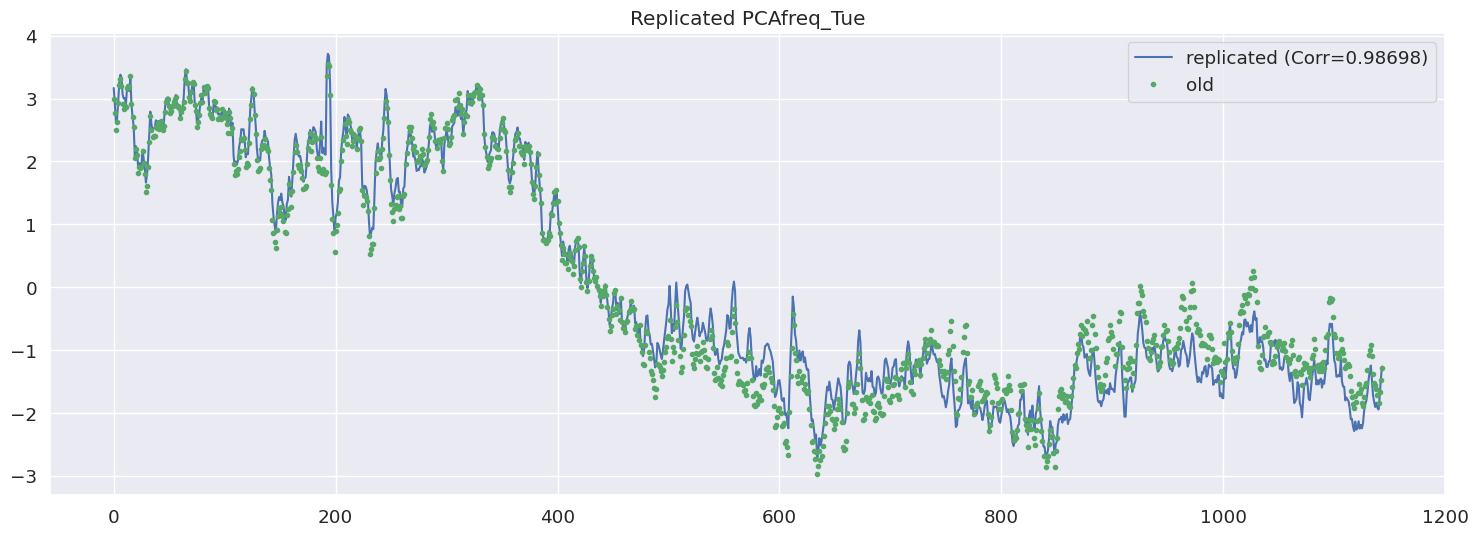

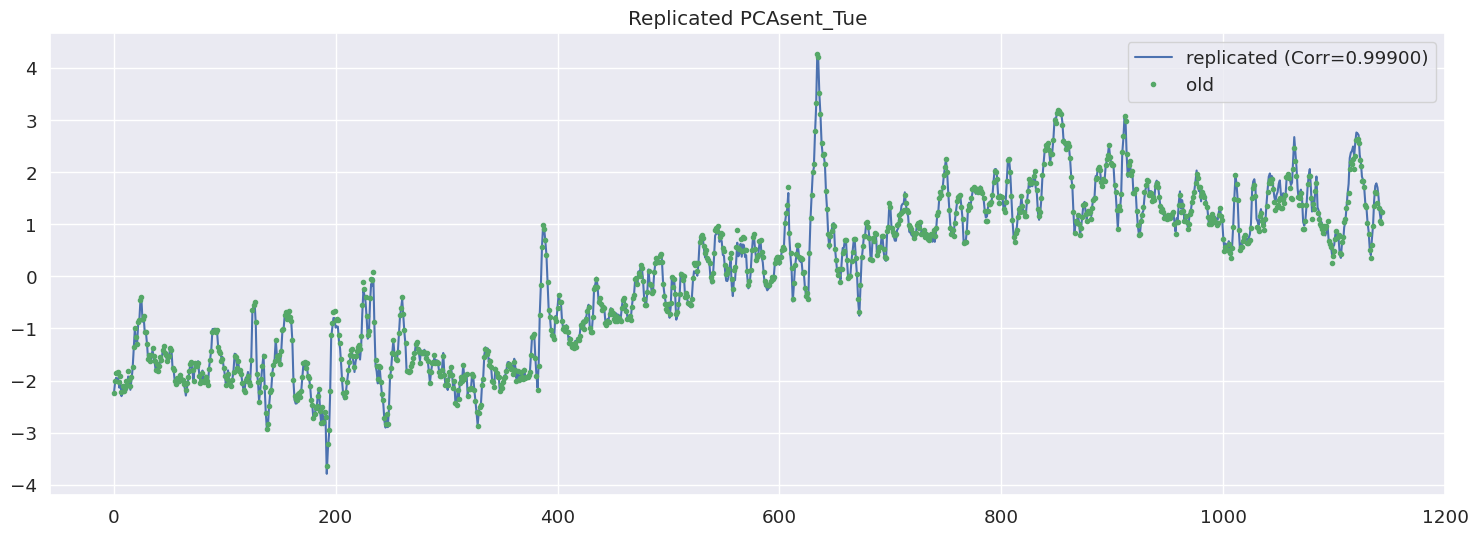

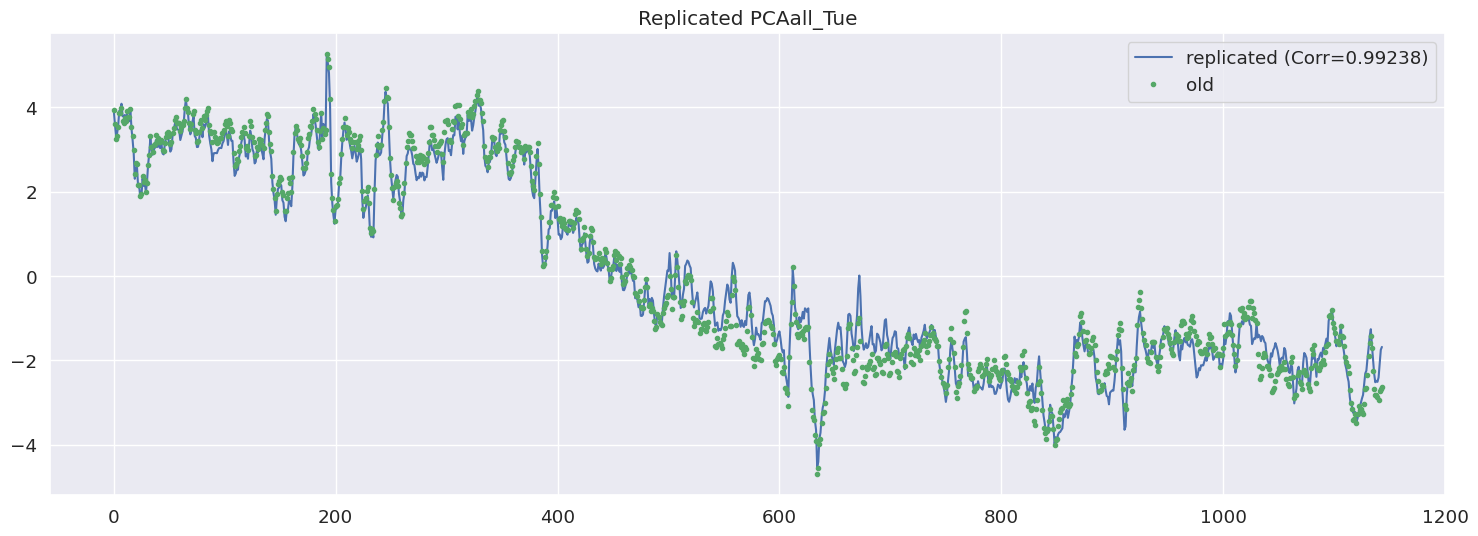

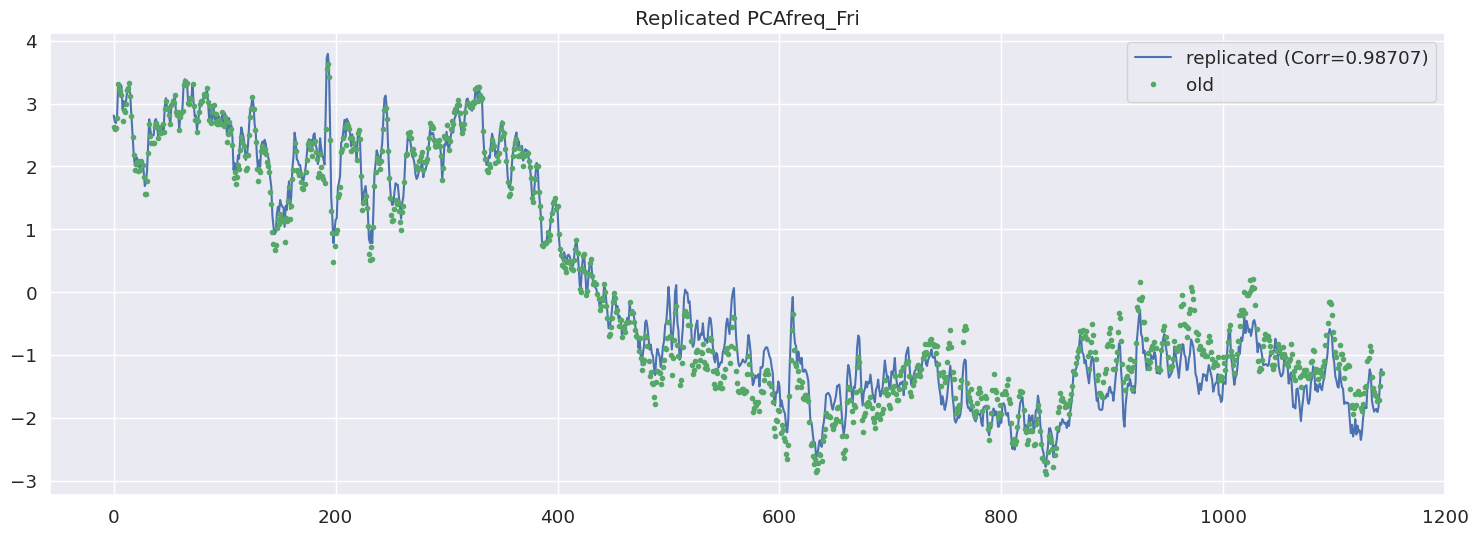

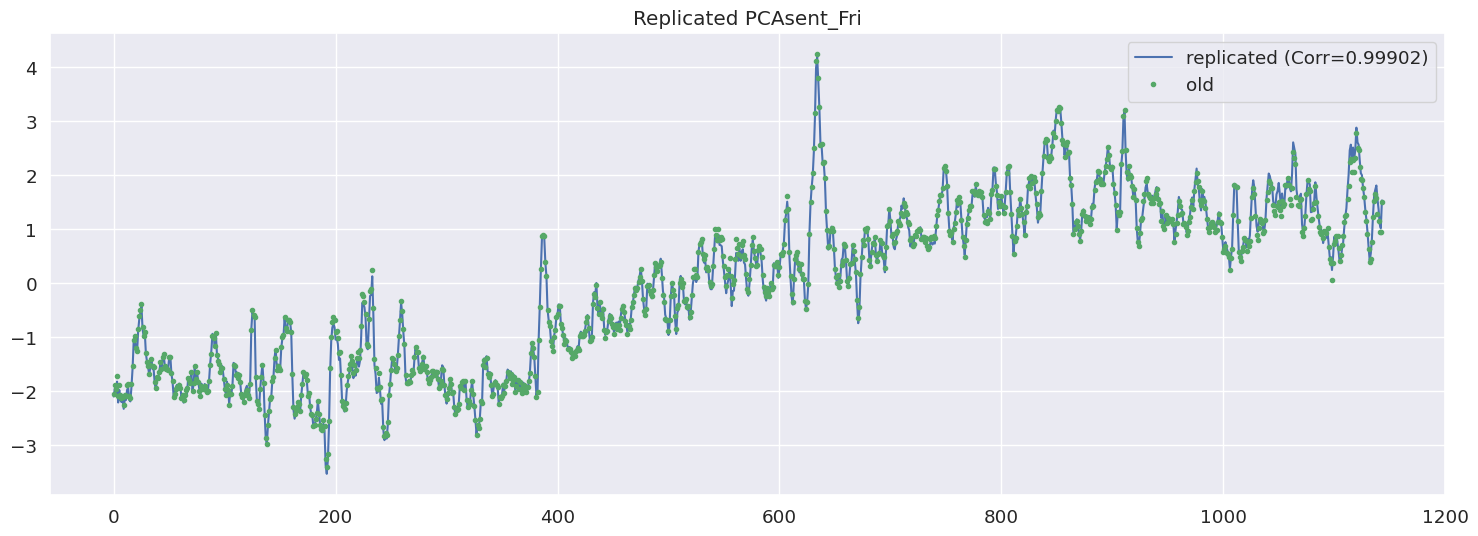

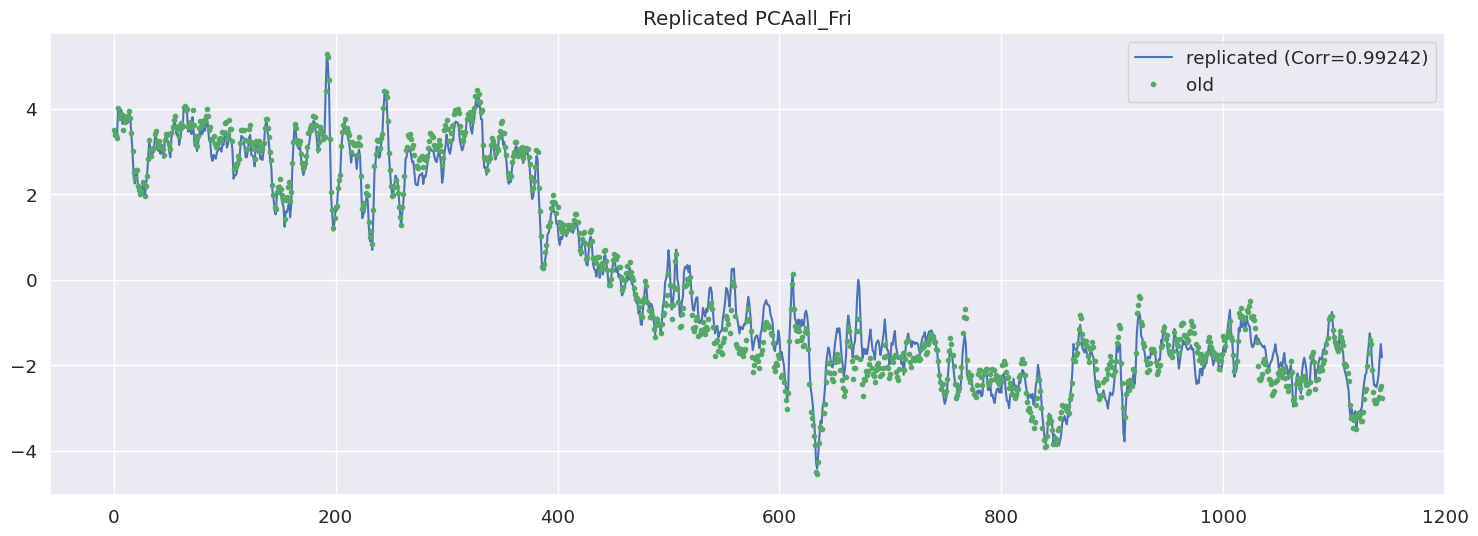

In [9]:
df_daily = read_new_df()
n_topics = sum([i.startswith('Topic-Sentiment') for i in df_daily.columns])

freq_vars = [f'Topic {i+1}' for i in range(n_topics)]
sent_vars = [f'Topic-Sentiment {i+1}' for i in range(n_topics)]
reg_cols = ['date', 'artcount_4wk', 'entropy_4wk']+\
            [f'stopic{i+1}_4wk' for i in range(n_topics)]+\
            [f'ftopic{i+1}_4wk' for i in range(n_topics)]

for end_of_week in weekdays:

    old = read_old_df(end_of_week)
    df = old[[f'{i}_{end_of_week}' for i in reg_cols]].dropna().copy()
    
    for pca_var_name, col_vars in zip(['freq', 'sent', 'all'], [freq_vars, sent_vars, freq_vars+sent_vars]):
        old_var = old[f'PCA{pca_var_name}_{end_of_week}'].dropna().values

        df_4wk, _ = get_df_4wk(df_daily, end_of_week)
        df_var = df_4wk[col_vars].dropna()
        if len(df_var) - len(old_var) == 1:
            df_var = df_var.iloc[1:]
        pca_var = get_pc1(df_var, scale=True)
        plot_check_pca(pca_var, old_var, title=f'{pca_var_name}_{end_of_week}')
        
        df[f'PCA{pca_var_name}_{end_of_week}'] = pca_var
        
    if end_of_week == 'Fri':
        df.to_stata('transformed_data_prices_v19.1.dta', write_index=False)
    elif end_of_week == 'Tue':
        df.to_stata('transformed_data_physical_v19.1.dta', write_index=False)

## Rolling PCA

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:07<00:00,  2.64s/it]


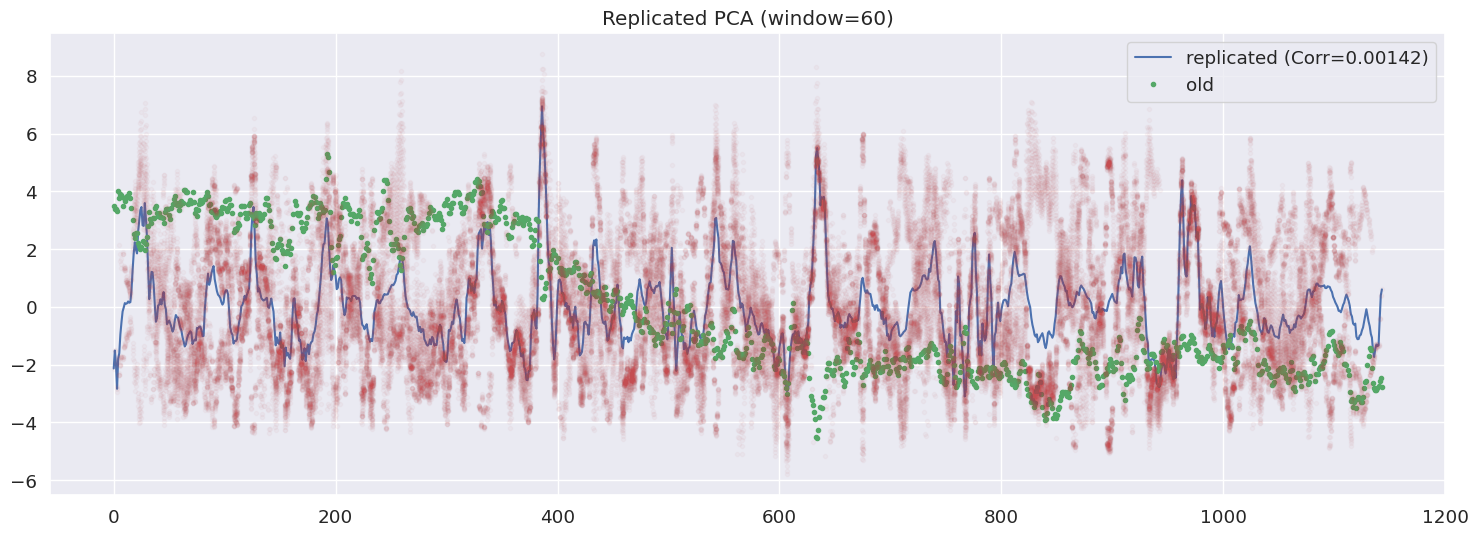

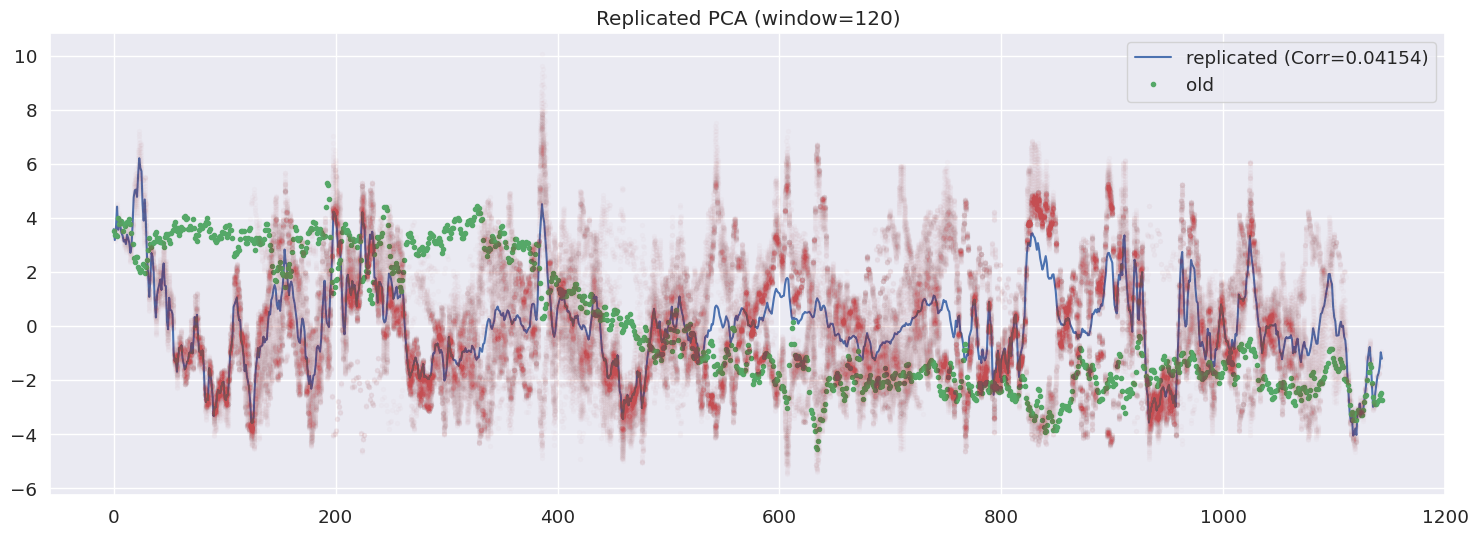

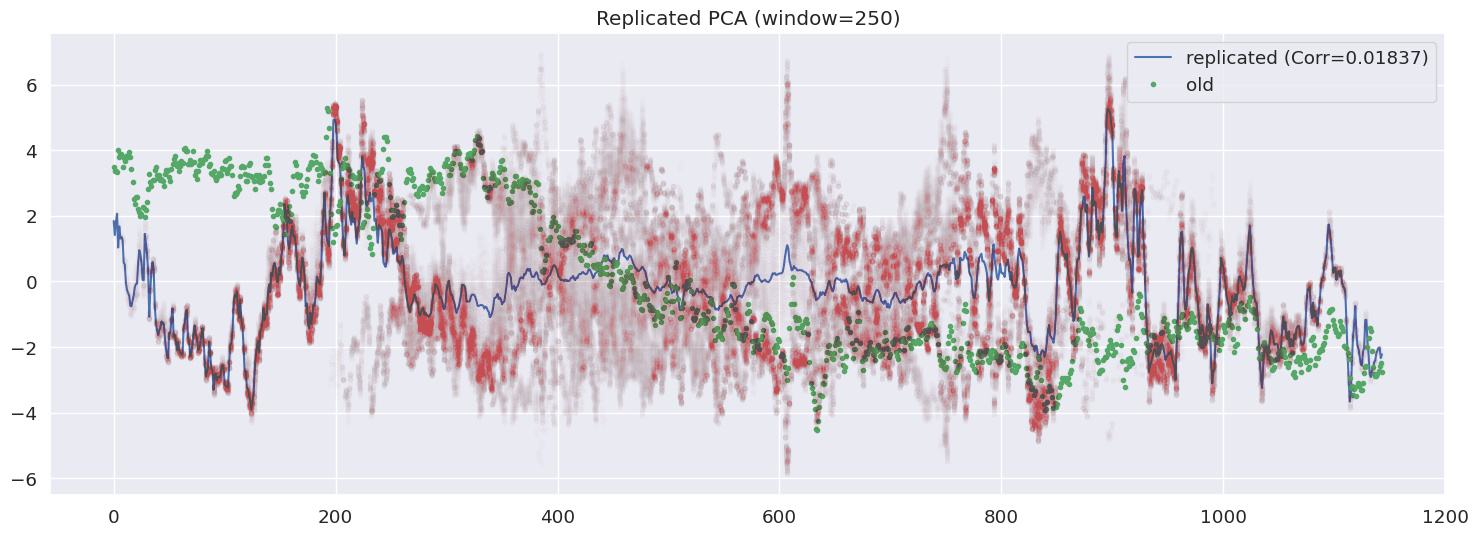

In [10]:
for window in tqdm([60, 120, 250]):#, 500, 800, 1000]):
    res = [pd.Series([np.nan]*i + list(get_pc1(df_var.iloc[i:i+window], scale=True)) + [np.nan]*(len(df_var)-i-window)) 
     for i in range(len(df_var)-window+1)]
    res_df = pd.concat(res, axis=1)
    fig, ax = plot_check_pca(res_df.mean(axis=1), old_var, title=f' (window={window})')
    ax.plot(res_df, '.r', alpha=2/window);

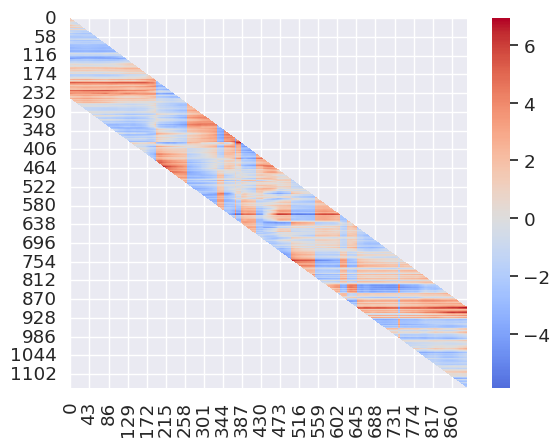

In [11]:
sns.heatmap(res_df, cmap='coolwarm', center=0);

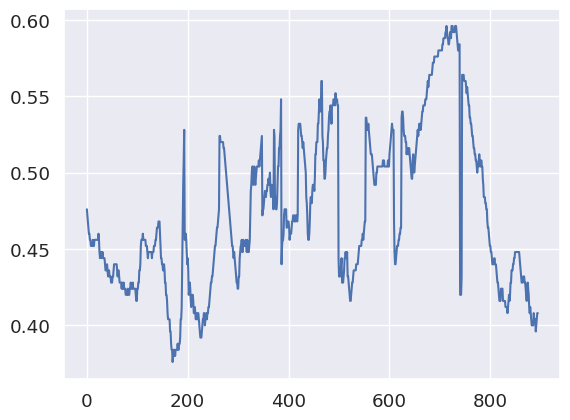

In [12]:
plt.plot((res_df>0).sum()/window);

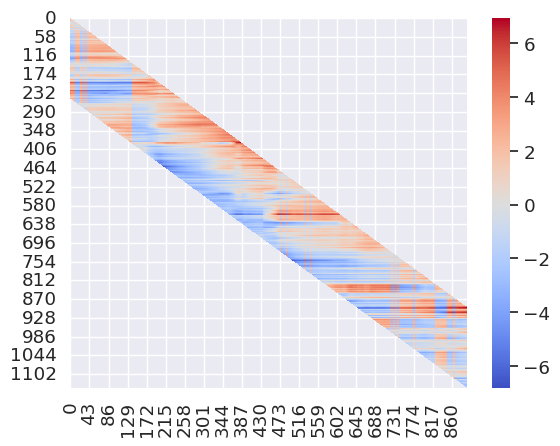

In [13]:
res_df_flip = res_df * (2*(np.diag(res_df)>0)-1)
sns.heatmap(res_df_flip, cmap='coolwarm', center=0);

In [37]:
for window in tqdm([60, 120, 250, 500, 800, 1000]):
    res = [pd.Series([np.nan]*i + list(get_pc1(df_var.iloc[i:i+window], scale=True)) + [np.nan]*(len(df_var)-i-window)) 
     for i in range(len(df_var)-window+1)]
    res_df = pd.concat(res, axis=1)
    res_df_flip = res_df * (2*(np.diag(res_df)>0)-1)
    fig, ax = plot_check_pca(res_df_flip.mean(axis=1), old_var, title=f' (window={window})')
    ax.plot(res_df_flip, '.r', alpha=2/window); 

  0%|                                                     | 0/6 [00:00<?, ?it/s]


NameError: name 'df_var' is not defined